## Data description

"Ministère de l'Environnement et de la Lutte contre les changements climatiques (MELCC)", 
2021. 

Physicochemical monitoring of rivers and rivers from 2000 to 2020, Quebec, Direction 
general monitoring of the state of the environment.

Metadata

https://www.donneesquebec.ca/recherche/dataset/bf2ca474-b331-4d35-ad09-351ca8f89b27/resource/cdc52e3c-0056-4d39-bbf7-f5804699cb5f/download/donneesquebec_physicochimie.pdf

Data source: 
https://www.donneesquebec.ca/recherche/dataset/suivi-physicochimique-des-rivieres-et-du-fleuve


## Import library

In [134]:
import os
import sys

import geopandas as gpd
import fiona as fiona
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import scipy.stats as stats

%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True'
# Pour la reproductibilité des résultats
np.random.seed(43)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('Do not show this message')

sns.set(rc={'figure.figsize':(10, 6)})
sns.set_theme(context="notebook", style="white", palette="pastel",font_scale=0.9)

## Load data

In [89]:
#read the geospatial data
f = r'D:\Daiana\Documents\AEC Intelligence artificielle\Hackathon 2 IA\data\physicochimie_2000_2020_json\AD_physicochimie_WGS84.json'
ff=r'D:\Daiana\Documents\AEC Intelligence artificielle\Hackathon 2 IA\data\physicochimie_2000_2020_json\IQBP_WGS84.json'
gdf=gpd.read_file(f)
gdf2=gpd.read_file(ff)

## Exploratory data analysis

In [90]:
gdf.head()

OBJECTID NO_STATION  SUPERF_QC_KM2  SUPERF_TOT_KM2 FRONTIERE  PC_AGRICOLE  \
0      1263   04310002        93683.0        143159.3        ON         2.48   
1      1264   06290002        79865.6         79865.6      None         2.03   
2      1265   06290013        72944.4         72944.4      None         1.91   
3      1266   06290012        72773.5         72773.5      None         1.80   
4      1267   07110001        46018.0         46018.0      None         0.00   

   PC_FORESTIER  PC_HUMIDE  PC_AQUATIQUE  PC_ANTHROPIQUE  \
0         69.37      11.87         11.41            0.95   
1         55.31      15.13          9.50            0.58   
2         54.16      15.37          9.74            0.42   
3         54.22      15.38          9.76            0.40   
4         62.95       9.65         13.21            0.23   

   PC_COUPE_REGENERATION  PC_SOL_NU_LANDE  PC_NON_CLASSIFIE  ANNEE_UT  \
0                   3.69                0              0.05      2018   
1                  15.91                0              0.04      2018   
2                  16.71                0              0.04      2018   
3                  16.74                0              0.04      2018   
4                   8.63                0              0.04      2018   

   Shape_Length    Shape_Area  \
0  6.038883e+06  3.044166e+11   
1  4.057730e+06  1.916073e+11   
2  4.081420e+06  1.758983e+11   
3  4.091098e+06  1.755096e+11   
4  3.698174e+06  1.186076e+11   

                                            geometry  
0  POLYGON ((-8330308.069 5668953.619, -8330255.7...  
1  POLYGON ((-8017339.612 6645610.164, -8017380.9...  
2  POLYGON ((-8017339.612 6645610.164, -8017380.9...  
3  POLYGON ((-8017339.612 6645610.164, -8017380.9...  
4  POLYGON ((-7846546.645 6855279.980, -7846607.2...

In [92]:
gdf.geometry.head()

0    POLYGON ((-8330308.069 5668953.619, -8330255.7...
1    POLYGON ((-8017339.612 6645610.164, -8017380.9...
2    POLYGON ((-8017339.612 6645610.164, -8017380.9...
3    POLYGON ((-8017339.612 6645610.164, -8017380.9...
4    POLYGON ((-7846546.645 6855279.980, -7846607.2...
Name: geometry, dtype: geometry

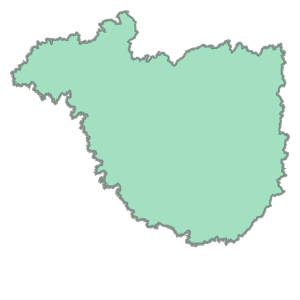

In [154]:
gdf['geometry'].iloc[0]

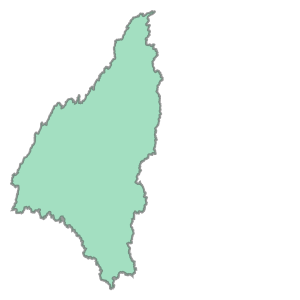

In [94]:
gdf.geometry.iloc[1]

<AxesSubplot:>

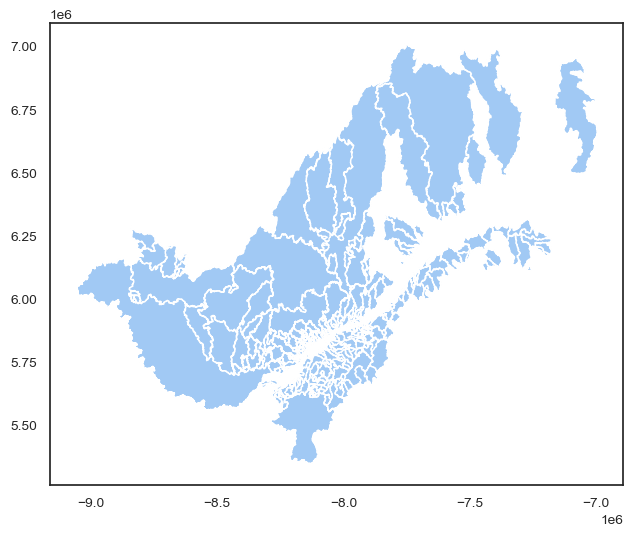

In [95]:
gdf.plot(figsize=(10,6))

In [96]:
max_area=gdf.SUPERF_QC_KM2.max()
gdf[gdf.SUPERF_QC_KM2==max_area]

OBJECTID NO_STATION  SUPERF_QC_KM2  SUPERF_TOT_KM2 FRONTIERE  PC_AGRICOLE  \
0      1263   04310002        93683.0        143159.3        ON         2.48   

   PC_FORESTIER  PC_HUMIDE  PC_AQUATIQUE  PC_ANTHROPIQUE  \
0         69.37      11.87         11.41            0.95   

   PC_COUPE_REGENERATION  PC_SOL_NU_LANDE  PC_NON_CLASSIFIE  ANNEE_UT  \
0                   3.69                0              0.05      2018   

   Shape_Length    Shape_Area  \
0  6.038883e+06  3.044166e+11   

                                            geometry  
0  POLYGON ((-8330308.069 5668953.619, -8330255.7...

In [97]:
gdf2.head()

OBJECTID   NO_STAT           NomCoursEau  \
0         1  00000009  Fleuve Saint-Laurent   
1         2  00000072  Fleuve Saint-Laurent   
2         3  00000075  Fleuve Saint-Laurent   
3         4  00000077  Fleuve Saint-Laurent   
4         5  00000078  Fleuve Saint-Laurent   

                                            DESCRIPT       TYP_STAT TYP_SUIV  \
0                              SAINT-LAURENT À SOREL  Réseau-fleuve  12 mois   
1  CANAL DE BEAUHARNOIS AU PONT-ROUTE 132 À VALLE...  Réseau-fleuve  12 mois   
2  SAINT-LAURENT CHENAL DU SUD EN AMONT DE LA MAR...  Réseau-fleuve  12 mois   
3           SAINT-LAURENT À LA PRISE D'EAU DE LAUZON  Réseau-fleuve  12 mois   
4  SAINT-LAURENT À LA PRISE D'EAU DE MONTRÉAL (LA...  Réseau-fleuve  12 mois   

     STAT_DEB    STAT_FIN  IQBP_N  IQBP_MED  ...  PTOT_MED  PTOT_Q90  \
0  2000-05-07  2000-10-01       6         6  ...       NaN       NaN   
1  1998-05-03  2000-10-01      14        90  ...       NaN       NaN   
2  1998-05-04  2000-10-02      17        81  ...       NaN       NaN   
3  1998-05-04  2000-10-02      14        76  ...       NaN       NaN   
4  1998-06-09  2000-10-02      16        90  ...       NaN       NaN   

   URL_ZGIEBV                                         URL_ZGIESL        LAT  \
0        None  http://www.environnement.gouv.qc.ca/eau/atlas/...  46.054539   
1        None  http://www.environnement.gouv.qc.ca/eau/atlas/...  45.224068   
2        None  http://www.environnement.gouv.qc.ca/eau/atlas/...  45.857759   
3        None  http://www.environnement.gouv.qc.ca/eau/atlas/...  46.832805   
4        None  http://www.environnement.gouv.qc.ca/eau/atlas/...  45.409040   

        LONG  NOM_ZGIEBV                            NOM_ZGIESL  ANNEE_FILTRE  \
0 -73.121283        None                      Lac Saint-Pierre          2000   
1 -74.115648        None  Haut-Saint-Laurent et Grand Montréal          2000   
2 -73.243911        None  Haut-Saint-Laurent et Grand Montréal          2000   
3 -71.151452        None                                Québec          2000   
4 -73.633272        None  Haut-Saint-Laurent et Grand Montréal          2000   

                           geometry  
0  POINT (-8139824.007 5789093.466)  
1  POINT (-8250516.228 5656865.712)  
2  POINT (-8153474.876 5757584.226)  
3  POINT (-7920543.417 5914826.230)  
4  POINT (-8196818.349 5686148.040)  

[5 rows x 37 columns]

<AxesSubplot:>

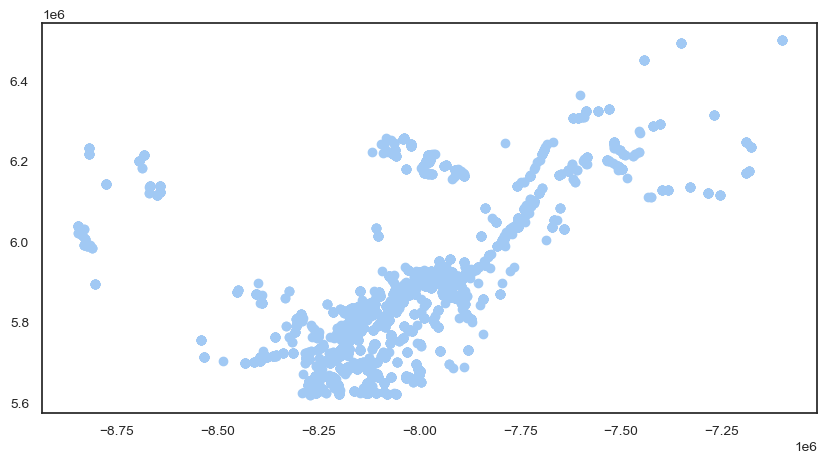

In [98]:
gdf2.plot(figsize=(10,6))

### Data set dimensions

#### Descriptive information – Physicochemical monitoring stations

In [99]:
print("Dimension of file Physicochemical monitoring stations")
print(gdf.shape)

Dimension of file Physicochemical monitoring stations
(402, 17)


##### Data type

In [100]:
gdf.describe()

OBJECTID  SUPERF_QC_KM2  SUPERF_TOT_KM2  PC_AGRICOLE  PC_FORESTIER  \
count   402.000000     402.000000      402.000000   402.000000    402.000000   
mean   1463.500000    2409.415672     2769.720647    27.226294     49.935199   
std     116.191652    9452.536412    11049.907623    26.387132     25.313104   
min    1263.000000       0.200000        0.300000     0.000000      0.000000   
25%    1363.250000      54.800000       61.925000     2.197500     27.825000   
50%    1463.500000     210.950000      219.550000    19.380000     53.725000   
75%    1563.750000    1021.625000     1051.225000    46.622500     73.437500   
max    1664.000000   93683.000000   143159.300000    97.270000     96.590000   

        PC_HUMIDE  PC_AQUATIQUE  PC_ANTHROPIQUE  PC_COUPE_REGENERATION  \
count  402.000000     402.00000      402.000000             402.000000   
mean    10.529900       2.84209        6.992438               2.195622   
std      9.435413       3.51852       12.417395               3.499013   
min      0.000000       0.00000        0.000000               0.000000   
25%      5.115000       0.28250        1.430000               0.170000   
50%      7.845000       1.08000        3.500000               0.900000   
75%     12.287500       4.36000        7.452500               2.577500   
max     69.710000      16.43000       97.330000              22.430000   

       PC_SOL_NU_LANDE  PC_NON_CLASSIFIE  ANNEE_UT  Shape_Length    Shape_Area  
count            402.0        402.000000     402.0  4.020000e+02  4.020000e+02  
mean               0.0          0.010970    2018.0  3.688422e+05  6.189050e+09  
std                0.0          0.023408       0.0  6.926430e+05  2.496761e+10  
min                0.0          0.000000    2018.0  4.876538e+03  5.893369e+05  
25%                0.0          0.000000    2018.0  6.500731e+04  1.307031e+08  
50%                0.0          0.000000    2018.0  1.440616e+05  4.715858e+08  
75%                0.0          0.010000    2018.0  3.480960e+05  2.304659e+09  
max                0.0          0.330000    2018.0  6.038883e+06  3.044166e+11

#### Descriptive information-Drainage areas of physicochemical monitoring stations

In [101]:
print("Dimension of file Drainage areas of physicochemical monitoring stations")
print(gdf2.shape)

Dimension of file Drainage areas of physicochemical monitoring stations
(5998, 37)


##### Data type

In [102]:
gdf2.describe()

OBJECTID       IQBP_N     IQBP_MED   IQBP_CLASS        NH3_N  \
count  5998.000000  5998.000000  5998.000000  5998.000000  5956.000000   
mean   2999.500000    15.912137    60.007836     2.452317    16.776528   
std    1731.617789     5.431685    28.142384     1.370006     7.669009   
min       1.000000     1.000000     0.000000     1.000000     1.000000   
25%    1500.250000    15.000000    40.000000     1.000000    16.000000   
50%    2999.500000    17.000000    67.000000     2.000000    17.000000   
75%    4498.750000    18.000000    85.000000     3.000000    18.000000   
max    5998.000000    70.000000    98.000000     5.000000    79.000000   

           NH3_MED      NH3_Q90       CHLA_N     CHLA_MED     CHLA_Q90  ...  \
count  5956.000000  5956.000000  5896.000000  5896.000000  5896.000000  ...   
mean      0.034354     0.092112    16.054274     2.775989     7.494454  ...   
std       0.063791     0.187675     5.264644     3.023807    10.701820  ...   
min       0.002000     0.005000     1.000000     0.110000     0.150000  ...   
25%       0.010000     0.030000    15.000000     1.350000     2.334750  ...   
50%       0.020000     0.049000    17.000000     2.072500     4.071500  ...   
75%       0.040000     0.089000    18.000000     3.300000     8.461250  ...   
max       2.100000     5.620000    67.000000   120.000000   222.700000  ...   

           MES_MED      MES_Q90        NOX_N      NOX_MED      NOX_Q90  \
count  5956.000000  5956.000000  5956.000000  5956.000000  5956.000000   
mean      8.139506    25.877099    16.943251     0.534610     1.116984   
std      10.906780    43.918687     7.950337     0.808483     1.833754   
min       0.500000     0.000000     1.000000     0.010000     0.010000   
25%       2.500000     7.000000    16.000000     0.105000     0.178000   
50%       5.000000    14.000000    17.000000     0.240000     0.379000   
75%       9.500000    28.250000    18.000000     0.610000     1.230000   
max     205.000000  1628.000000    79.000000    10.000000    30.400000   

            PTOT_N     PTOT_MED     PTOT_Q90          LAT         LONG  
count  4187.000000  4187.000000  4187.000000  5998.000000  5998.000000  
mean     16.714115     0.043098     0.087535    46.501632   -72.401316  
std       9.577291     0.075782     0.136297     1.094142     2.249383  
min       1.000000     0.001000     0.001000    44.992240   -79.484222  
25%      12.000000     0.011000     0.020000    45.655441   -73.450222  
50%      17.000000     0.021000     0.042000    46.308958   -72.537659  
75%      18.000000     0.052000     0.107000    46.855832   -71.348189  
max      79.000000     2.700000     2.700000    50.306360   -63.786856  

[8 rows x 24 columns]

#### Merge files

In [103]:
gdf2[gdf2.NO_STAT=="04310002"]

OBJECTID   NO_STAT            NomCoursEau  \
130        131  04310002  Rivière des Outaouais   
324        325  04310002  Rivière des Outaouais   
527        528  04310002  Rivière des Outaouais   
737        738  04310002  Rivière des Outaouais   
942        943  04310002  Rivière des Outaouais   
1183      1184  04310002  Rivière des Outaouais   
1437      1438  04310002  Rivière des Outaouais   
1698      1699  04310002  Rivière des Outaouais   
1956      1957  04310002  Rivière des Outaouais   
2234      2235  04310002  Rivière des Outaouais   
2518      2519  04310002  Rivière des Outaouais   
2797      2798  04310002  Rivière des Outaouais   
3085      3086  04310002  Rivière des Outaouais   
3418      3419  04310002  Rivière des Outaouais   
3756      3757  04310002  Rivière des Outaouais   
4105      4106  04310002  Rivière des Outaouais   
4462      4463  04310002  Rivière des Outaouais   
4820      4821  04310002  Rivière des Outaouais   
5169      5170  04310002  Rivière des Outaouais   
5518      5519  04310002  Rivière des Outaouais   
5858      5859  04310002  Rivière des Outaouais   

                                               DESCRIPT         TYP_STAT  \
130   DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
324   DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
527   DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
737   DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
942   DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
1183  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
1437  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
1698  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
1956  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
2234  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
2518  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
2797  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
3085  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
3418  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
3756  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
4105  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
4462  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
4820  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
5169  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
5518  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
5858  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   

     TYP_SUIV    STAT_DEB    STAT_FIN  IQBP_N  IQBP_MED  ...  PTOT_MED  \
130   12 mois  1998-05-18  2000-10-09      15        85  ...       NaN   
324   12 mois  1999-05-10  2001-10-21      15        85  ...       NaN   
527   12 mois  2000-05-14  2002-10-14      16        85  ...       NaN   
737   12 mois  2001-05-14  2003-10-13      18        85  ...       NaN   
942   12 mois  2002-05-12  2004-10-11      17        79  ...       NaN   
1183  12 mois  2003-05-11  2005-10-10      17        81  ...       NaN   
1437  12 mois  2004-05-09  2006-10-09      17        81  ...       NaN   
1698  12 mois  2005-05-08  2007-10-14      18        82  ...       NaN   
1956  12 mois  2006-05-14  2008-10-13      17        81  ...       NaN   
2234  12 mois  2007-05-13  2009-10-13      17        85  ...     0.018   
2518  12 mois  2008-05-19  2010-10-12      17        84  ...     0.019   
2797  12 mois  2009-05-03  2011-09-05      17        83  ...     0.019   
3085  12 mois  2010-05-09  2012-10-08      17        80  ...     0.018   
3418  12 mois  2011-05-10  2013-10-15      17        78  ...     0.017   
3756  12 mois  2012-05-13  2014-10-14      18        82  ...     0.017   
4105  12 mois  2013-05-13 

In [104]:
gdf2.rename(columns={'NO_STAT': "NO_STATION"},inplace=True)

In [105]:
df = pd.merge(gdf2,gdf,on='NO_STATION', how='left')


In [106]:
df.describe()

OBJECTID_x       IQBP_N     IQBP_MED   IQBP_CLASS        NH3_N  \
count  5998.000000  5998.000000  5998.000000  5998.000000  5956.000000   
mean   2999.500000    15.912137    60.007836     2.452317    16.776528   
std    1731.617789     5.431685    28.142384     1.370006     7.669009   
min       1.000000     1.000000     0.000000     1.000000     1.000000   
25%    1500.250000    15.000000    40.000000     1.000000    16.000000   
50%    2999.500000    17.000000    67.000000     2.000000    17.000000   
75%    4498.750000    18.000000    85.000000     3.000000    18.000000   
max    5998.000000    70.000000    98.000000     5.000000    79.000000   

           NH3_MED      NH3_Q90       CHLA_N     CHLA_MED     CHLA_Q90  ...  \
count  5956.000000  5956.000000  5896.000000  5896.000000  5896.000000  ...   
mean      0.034354     0.092112    16.054274     2.775989     7.494454  ...   
std       0.063791     0.187675     5.264644     3.023807    10.701820  ...   
min       0.002000     0.005000     1.000000     0.110000     0.150000  ...   
25%       0.010000     0.030000    15.000000     1.350000     2.334750  ...   
50%       0.020000     0.049000    17.000000     2.072500     4.071500  ...   
75%       0.040000     0.089000    18.000000     3.300000     8.461250  ...   
max       2.100000     5.620000    67.000000   120.000000   222.700000  ...   

       PC_FORESTIER    PC_HUMIDE  PC_AQUATIQUE  PC_ANTHROPIQUE  \
count   4457.000000  4457.000000   4457.000000     4457.000000   
mean      52.260738    11.025961      3.514039        5.124249   
std       24.187421     9.016509      3.680354        7.243089   
min        0.000000     0.000000      0.000000        0.000000   
25%       31.070000     5.720000      0.530000        1.320000   
50%       56.530000     8.460000      1.950000        3.350000   
75%       74.570000    12.300000      5.800000        5.820000   
max       96.590000    69.710000     16.430000       97.330000   

       PC_COUPE_REGENERATION  PC_SOL_NU_LANDE  PC_NON_CLASSIFIE  ANNEE_UT  \
count            4457.000000           4457.0       4457.000000    4457.0   
mean                2.547552              0.0          0.013211    2018.0   
std                 3.700841              0.0          0.022690       0.0   
min                 0.000000              0.0          0.000000    2018.0   
25%                 0.270000              0.0          0.000000    2018.0   
50%                 1.430000              0.0          0.010000    2018.0   
75%                 2.910000              0.0          0.020000    2018.0   
max                22.430000              0.0          0.330000    2018.0   

       Shape_Length    Shape_Area  
count  4.457000e+03  4.457000e+03  
mean   5.184329e+05  9.790854e+09  
std    8.344223e+05  3.258204e+10  
min    4.876538e+03  5.893369e+05  
25%    1.097282e+05  3.325041e+08  
50%    2.390749e+05  1.107366e+09  
75%    4.829495e+05  3.552380e+09  
max    6.038883e+06  3.044166e+11  

[8 rows x 38 columns]

In [110]:
df[df.NO_STATION=="04310002"]

OBJECTID_x NO_STATION            NomCoursEau  \
130          131   04310002  Rivière des Outaouais   
324          325   04310002  Rivière des Outaouais   
527          528   04310002  Rivière des Outaouais   
737          738   04310002  Rivière des Outaouais   
942          943   04310002  Rivière des Outaouais   
1183        1184   04310002  Rivière des Outaouais   
1437        1438   04310002  Rivière des Outaouais   
1698        1699   04310002  Rivière des Outaouais   
1956        1957   04310002  Rivière des Outaouais   
2234        2235   04310002  Rivière des Outaouais   
2518        2519   04310002  Rivière des Outaouais   
2797        2798   04310002  Rivière des Outaouais   
3085        3086   04310002  Rivière des Outaouais   
3418        3419   04310002  Rivière des Outaouais   
3756        3757   04310002  Rivière des Outaouais   
4105        4106   04310002  Rivière des Outaouais   
4462        4463   04310002  Rivière des Outaouais   
4820        4821   04310002  Rivière des Outaouais   
5169        5170   04310002  Rivière des Outaouais   
5518        5519   04310002  Rivière des Outaouais   
5858        5859   04310002  Rivière des Outaouais   

                                               DESCRIPT         TYP_STAT  \
130   DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
324   DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
527   DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
737   DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
942   DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
1183  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
1437  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
1698  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
1956  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
2234  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
2518  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
2797  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
3085  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
3418  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
3756  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
4105  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
4462  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
4820  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
5169  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
5518  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   
5858  DES OUTAOUAIS AU BARRAGE D'HYDRO-QUÉBEC À CARI...  Réseau-rivières   

     TYP_SUIV    STAT_DEB    STAT_FIN  IQBP_N  IQBP_MED  ...  PC_HUMIDE  \
130   12 mois  1998-05-18  2000-10-09      15        85  ...      11.87   
324   12 mois  1999-05-10  2001-10-21      15        85  ...      11.87   
527   12 mois  2000-05-14  2002-10-14      16        85  ...      11.87   
737   12 mois  2001-05-14  2003-10-13      18        85  ...      11.87   
942   12 mois  2002-05-12  2004-10-11      17        79  ...      11.87   
1183  12 mois  2003-05-11  2005-10-10      17        81  ...      11.87   
1437  12 mois  2004-05-09  2006-10-09      17        81  ...      11.87   
1698  12 mois  2005-05-08  2007-10-14      18        82  ...      11.87   
1956  12 mois  2006-05-14  2008-10-13      17        81  ...      11.87   
2234  12 mois  2007-05-13  2009-10-13      17        85  ...      11.87   
2518  12 mois  2008-05-19  2010-10-12      17        84  ...      11.87   
2797  12 mois  2009-05-03  2011-09-05      17        83  ...      11.87   
3085  12 mois  2010-05-09  2012-10-08      17        80  ...      11.87   
3418  12 mois  2011-05-10  2013-10-15      17        78  ...      11.87   
3756  12 mois  2012

In [111]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5998 entries, 0 to 5997
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   OBJECTID_x             5998 non-null   int64   
 1   NO_STATION             5998 non-null   object  
 2   NomCoursEau            5998 non-null   object  
 3   DESCRIPT               5998 non-null   object  
 4   TYP_STAT               5998 non-null   object  
 5   TYP_SUIV               5998 non-null   object  
 6   STAT_DEB               5998 non-null   object  
 7   STAT_FIN               5998 non-null   object  
 8   IQBP_N                 5998 non-null   int64   
 9   IQBP_MED               5998 non-null   int64   
 10  IQBP_CLASS             5998 non-null   int64   
 11  NH3_N                  5956 non-null   float64 
 12  NH3_MED                5956 non-null   float64 
 13  NH3_Q90                5956 non-null   float64 
 14  CHLA_N                 5896 non-

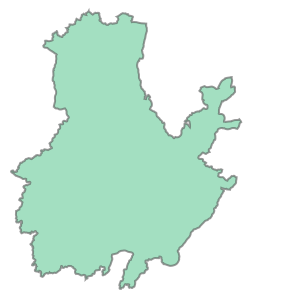

In [112]:
df.geometry_y.iloc[5993]

In [113]:
#lister les  occurences de chacune des occurences non-numériques
for key in df.select_dtypes(exclude='number').columns:
    print("\n---- %s ----" % key)
    print(df[key].value_counts())


---- NO_STATION ----
06290002    21
04040001    21
03090009    21
03090046    21
03090047    21
            ..
02310051     1
02200055     1
06G06001     1
06340001     1
07A30001     1
Name: NO_STATION, Length: 856, dtype: int64

---- NomCoursEau ----
Fleuve Saint-Laurent      617
Rivière Yamaska           111
Rivière du Loup           110
Rivière Saint-François    109
Rivière Chaudière         105
                         ... 
Rivière Kempt               1
Rivière des Sept Îles       1
Rivière Milky               1
Rivière Du Bas De Soie      1
Rivière à la Truite         1
Name: NomCoursEau, Length: 403, dtype: int64

---- DESCRIPT ----
SAINT-LAURENT SOUS LE PONT LAVIOLETTE À TROIS-RIVIÈRES (RIVE NORD)                                     22
SAINT-LAURENT ENTRE REPENTIGNY ET VARENNES (RIVE NORD,VOIE MARITIME)                                   22
SAINT-LAURENT AU PORT DE BÉCANCOUR (RIVE SUD)                                                          22
CHÂTEAUGUAY À GUÉ À 1,6 KM EN AVA

AttributeError: 'GeometryArray' object has no attribute 'value_counts'

### Data visualization

In [115]:
df.columns

Index(['OBJECTID_x', 'NO_STATION', 'NomCoursEau', 'DESCRIPT', 'TYP_STAT',
       'TYP_SUIV', 'STAT_DEB', 'STAT_FIN', 'IQBP_N', 'IQBP_MED', 'IQBP_CLASS',
       'NH3_N', 'NH3_MED', 'NH3_Q90', 'CHLA_N', 'CHLA_MED', 'CHLA_Q90', 'CF_N',
       'CF_MED', 'CF_Q90', 'MES_N', 'MES_MED', 'MES_Q90', 'NOX_N', 'NOX_MED',
       'NOX_Q90', 'PTOT_N', 'PTOT_MED', 'PTOT_Q90', 'URL_ZGIEBV', 'URL_ZGIESL',
       'LAT', 'LONG', 'NOM_ZGIEBV', 'NOM_ZGIESL', 'ANNEE_FILTRE', 'geometry_x',
       'OBJECTID_y', 'SUPERF_QC_KM2', 'SUPERF_TOT_KM2', 'FRONTIERE',
       'PC_AGRICOLE', 'PC_FORESTIER', 'PC_HUMIDE', 'PC_AQUATIQUE',
       'PC_ANTHROPIQUE', 'PC_COUPE_REGENERATION', 'PC_SOL_NU_LANDE',
       'PC_NON_CLASSIFIE', 'ANNEE_UT', 'Shape_Length', 'Shape_Area',
       'geometry_y'],
      dtype='object')

In [116]:
features=['NO_STATION', 'NomCoursEau','TYP_STAT','TYP_SUIV', 'STAT_DEB', 'STAT_FIN', 'IQBP_N', 'IQBP_MED', 'IQBP_CLASS',
       'NH3_N', 'NH3_MED', 'NH3_Q90', 'CHLA_N', 'CHLA_MED', 'CHLA_Q90', 'CF_N',
       'CF_MED', 'CF_Q90', 'MES_N', 'MES_MED', 'MES_Q90', 'NOX_N', 'NOX_MED',
       'NOX_Q90', 'PTOT_N', 'PTOT_MED', 'PTOT_Q90', 'URL_ZGIEBV', 'URL_ZGIESL',
       'LAT', 'LONG', 'NOM_ZGIEBV', 'NOM_ZGIESL', 'ANNEE_FILTRE','SUPERF_QC_KM2', 'SUPERF_TOT_KM2', 'FRONTIERE',
       'PC_AGRICOLE', 'PC_FORESTIER', 'PC_HUMIDE', 'PC_AQUATIQUE',
       'PC_ANTHROPIQUE', 'PC_COUPE_REGENERATION', 'PC_SOL_NU_LANDE',
       'PC_NON_CLASSIFIE', 'ANNEE_UT']

#### Year

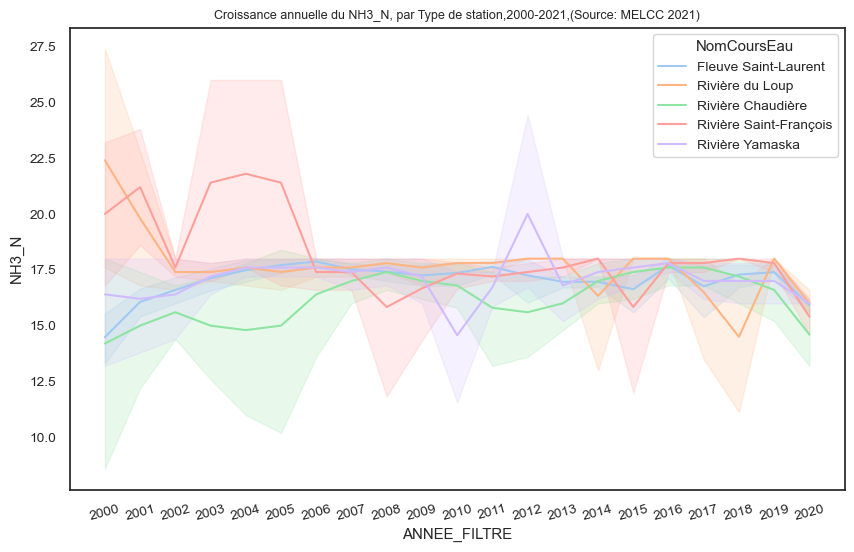

In [138]:
filter_cours=df.NomCoursEau.isin(["Fleuve Saint-Laurent","Rivière Yamaska","Rivière du Loup","Rivière Saint-François","Rivière Chaudière"])
sns.lineplot(data=df[filter_cours], 
             x="ANNEE_FILTRE", 
             y='NH3_N',
             hue='NomCoursEau',
             markers=True,
             dashes=False)

plt.title(label='Croissance annuelle du NH3_N, 2000-2021,(Source: MELCC 2021)',fontdict={'fontsize':9}, loc='center')
plt.xticks(rotation=15)
plt.show()

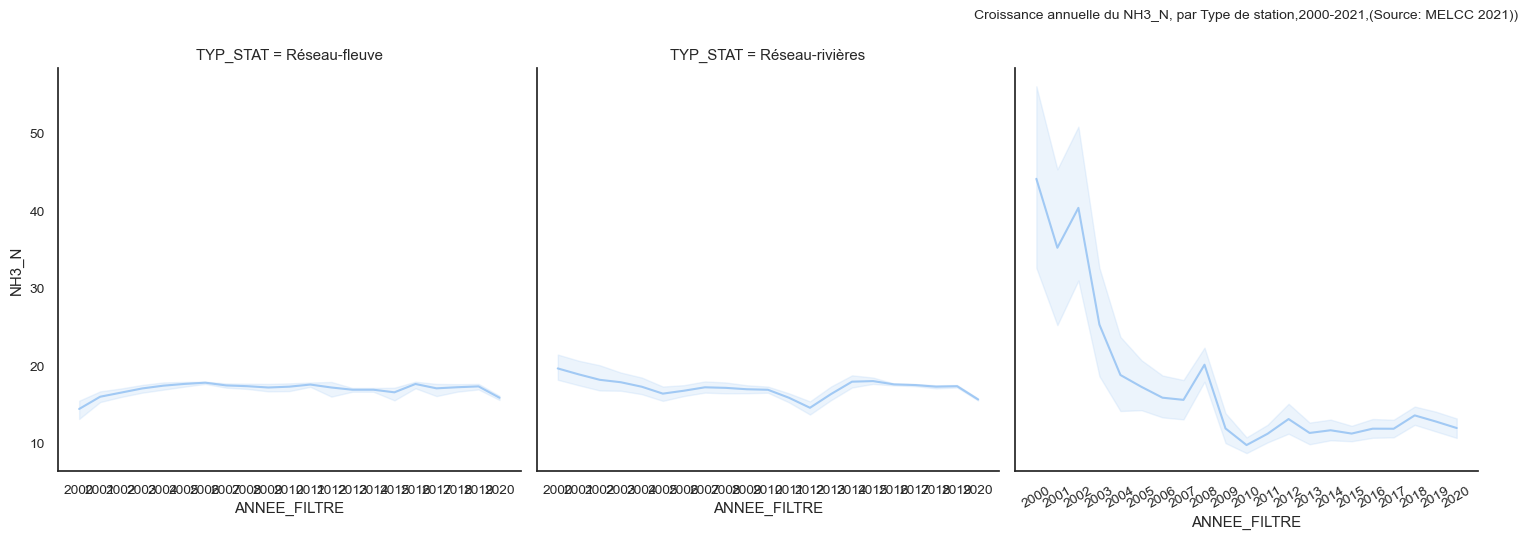

In [141]:
# relational plot
#filter_cours=df.NomCoursEau.isin(["Fleuve Saint-Laurent","Rivière Yamaska","Rivière du Loup","Rivière Saint-François","Rivière Chaudière"])
sns.relplot(data=df,
            x="ANNEE_FILTRE", 
             y='NH3_N',
             col='TYP_STAT',
             kind='line',
             #markers=True, 
            dashes=True
            
            )
plt.title(label='Croissance annuelle du NH3_N, par Type de station,2000-2021,(Source: MELCC 2021))',
          fontdict={'fontsize':10}, loc='center',y=1.1)
plt.xticks(rotation=30)
plt.show()

In [143]:
df.IQBP_CLASS.unique()

array([5, 1, 2, 3, 4], dtype=int64)

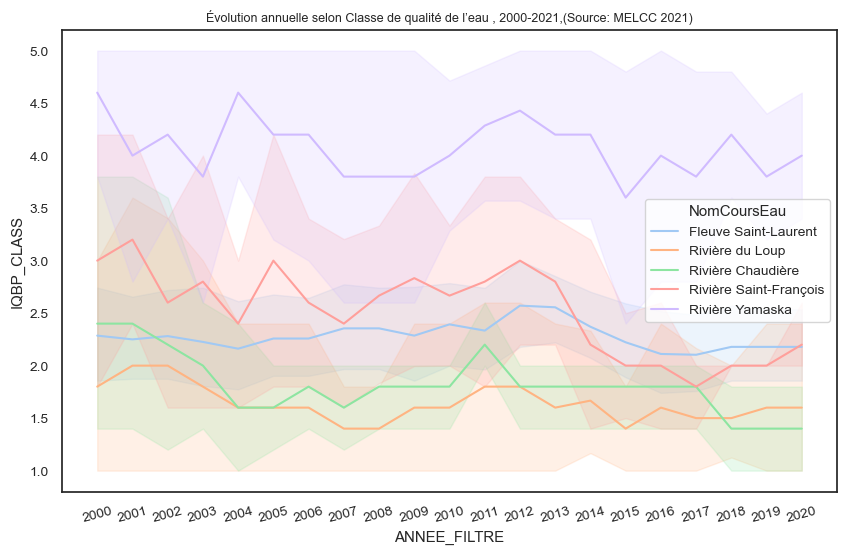

In [142]:
filter_cours=df.NomCoursEau.isin(["Fleuve Saint-Laurent","Rivière Yamaska","Rivière du Loup","Rivière Saint-François","Rivière Chaudière"])
sns.lineplot(data=df[filter_cours], 
             x="ANNEE_FILTRE", 
             y='IQBP_CLASS',
             hue='NomCoursEau',
             markers=True,
             dashes=False)

plt.title(label='Évolution annuelle selon Classe de qualité de l’eau , 2000-2021,(Source: MELCC 2021)',fontdict={'fontsize':9}, loc='center')
plt.xticks(rotation=15)
plt.show()

The Yamaska River has the best water quality with a classification index between 4 and 4.5.

As of 2013, the classification index is declining for the St. Lawrence River.

A decrease of 0.5 points is noted for the Chaudière River which goes from 2.0 to 1.5

In [163]:
dfg=gpd.GeoDataFrame(df)

In [180]:
filter_cours=df.NomCoursEau.isin(["Rivière Chaudière"])
df[filter_cours]

OBJECTID_x NO_STATION        NomCoursEau  \
47            48   02340004  Rivière Chaudière   
48            49   02340006  Rivière Chaudière   
49            50   02340014  Rivière Chaudière   
50            51   02340033  Rivière Chaudière   
52            53   02340050  Rivière Chaudière   
...          ...        ...                ...   
5726        5727   02340004  Rivière Chaudière   
5727        5728   02340006  Rivière Chaudière   
5728        5729   02340014  Rivière Chaudière   
5729        5730   02340033  Rivière Chaudière   
5732        5733   02340050  Rivière Chaudière   

                                               DESCRIPT         TYP_STAT  \
47    CHAUDIÈRE AU PONT COUVERT PERREAULT À NOTRE-DA...  Réseau-rivières   
48    CHAUDIÈRE AU PONT DU CHEMIN DU LAC DROLET AU S...  Réseau-rivières   
49    CHAUDIÈRE AU PONT-ROUTE 171 À SCOTT, À L'OUEST...  Réseau-rivières   
50    CHAUDIÈRE À 5,6 KM DE L'EMBOUCHURE À LA PRISE ...  Réseau-rivières   
52    CHAUDIÈRE AU PONT-ROUTE 132 À SAINT-ROMUALD À ...            Autre   
...                                                 ...              ...   
5726  CHAUDIÈRE AU PONT COUVERT PERREAULT À NOTRE-DA...  Réseau-rivières   
5727  CHAUDIÈRE AU PONT DU CHEMIN DU LAC DROLET AU S...  Réseau-rivières   
5728  CHAUDIÈRE AU PONT-ROUTE 171 À SCOTT, À L'OUEST...  Réseau-rivières   
5729  CHAUDIÈRE À 5,6 KM DE L'EMBOUCHURE À LA PRISE ...  Réseau-rivières   
5732  CHAUDIÈRE AU PONT-ROUTE 132 À SAINT-ROMUALD À ...  Réseau-rivières   

     TYP_SUIV    STAT_DEB    STAT_FIN  IQBP_N  IQBP_MED  ...  PC_HUMIDE  \
47     8 mois  1998-05-03  2000-10-01      13        80  ...      11.73   
48     8 mois  1998-05-03  2000-10-02      17        71  ...       8.58   
49     8 mois  1998-05-04  2000-10-02      16        74  ...      10.20   
50    12 mois  1998-05-04  2000-10-02      12        72  ...      12.06   
52     8 mois  2000-05-11  2000-10-12       4         0  ...      12.16   
...       ...         ...         ...     ...       ...  ...        ...   
5726   8 mois  2018-06-06  2020-10-06      12        71  ...      11.73   
5727   8 mois  2018-05-07  2020-10-13      15        89  ...       8.58   
5728   8 mois  2018-05-15  2020-10-06      14        86  ...      10.20   
5729  12 mois  2018-05-07  2020-10-05      14        80  ...      12.06   
5732   8 mois  2018-05-10  2020-10-08      16        63  ...      12.16   

      PC_AQUATIQUE  PC_ANTHROPIQUE  PC_COUPE_REGENERATION  PC_SOL_NU_LANDE  \
47            1.98            2.78                   2.23              0.0   
48            4.02            2.49                   2.71              0.0   
49            1.63            3.31                   1.71              0.0   
50            1.58            3.60                   1.72              0.0   
52            1.58            3.86                   1.71              0.0   
...            ...             ...                    ...              ...   
5726          1.98            2.78                   2.23              0.0   
5727          4.02            2.49                   2.71              0.0   
5728          1.63            3.31                   1.71              0.0   
5729          1.58            3.60                   1.72              0.0   
5732          1.58            3.86                   1.71              0.0   

      PC_NON_CLASSIFIE  ANNEE_UT  Shape_Length    Shape_Area  \
47                0.01    2018.0  7.131442e+05  8.422757e+09   
48                0.01    2018.0  3.058682e+05  2.312530e+09   
49                0.01    2018.0  9.005079e+05  1.184614e+10   
50                0.01    2018.0  1.072660e+06  1.373829e+10   
52                0.01    2018.0  1.084491e+06  1.385462e+10   
...                ...       ...           ...           ...   
5726              0.01    2018.0  7.131442e+05  8.422757e+09   
5727              0.01    2018.0  3.058682e+05  2.312530e+09   
5728              0.01    2018.0  9.005079e+05  1.184614e+10   
5729          

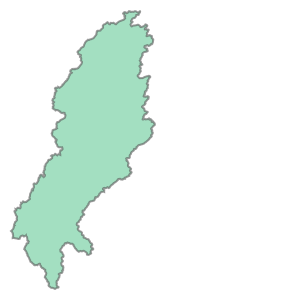

In [183]:
dfg[filter_cours]['geometry_y'].iloc[50]

In [191]:
dfChaudiere=pd.read_excel(dfg.iloc[5729]["URL_ZGIEBV"],sheet_name='Données brutes')

In [193]:
dfChaudiere.dropna()

N° PROJET  N° STATION       DATE   HEURE LABO ABRÉVIATION  \
5         210.0   2340004.0 2018-04-10  1315.0  DLQ         NH3   
48        210.0   2340004.0 2018-10-09  1115.0  DLQ         NH3   
62        210.0   2340004.0 2018-11-06  1343.0  DLQ         NH3   
176       210.0   2340004.0 2019-10-16  1410.0  DLQ         NH3   
258       210.0   2340004.0 2020-09-08   845.0  DLQ     P-D-PER   
...         ...         ...        ...     ...  ...         ...   
2771      210.0   2340051.0 2019-08-05  1300.0  DLQ         NH3   
2811      210.0   2340051.0 2019-10-07  1215.0  DLQ         NH3   
2850      210.0   2340051.0 2020-06-01  1230.0  DLQ         NH3   
3001      210.0   2340131.0 2018-08-07  1500.0  DLQ         NH3   
3016      210.0   2340131.0 2018-09-04  1600.0  DLQ         NH3   

          N° MÉTHODE VALEUR  UNITÉ UNITÉ.1  
5     303-NUTRIMENTS      <  0.020    mg/l  
48    303-NUTRIMENTS      <  0.020    mg/l  
62    303-NUTRIMENTS      <  0.020    mg/l  
176   303-NUTRIMENTS      <  0.020    mg/l  
258        303-P 5.2      <  0.002    mg/l  
...              ...    ...    ...     ...  
2771  303-NUTRIMENTS      <  0.020    mg/l  
2811  303-NUTRIMENTS      <  0.020    mg/l  
2850  303-NUTRIMENTS      <  0.020    mg/l  
3001  303-NUTRIMENTS      <  0.020    mg/l  
3016  303-NUTRIMENTS      <  0.020    mg/l  

[91 rows x 10 columns]

In [218]:
dfChaudiere["N° MÉTHODE"].unique()

array([nan, 'TERRAIN', '300-C 1.0', '303-TITRAUTO 2.1', '700-FEC.EC. 1.0',
       '303-NUTRIMENTS', '303-P 5.2', '104-S.S. 2.0', '103-TUR. 1.0',
       '800-CHLOR. 1.0', '203-MÉT. ICP-MS', '303-ANIONS 1.1'],
      dtype=object)

In [200]:
dfChaudiere.ABRÉVIATION.unique()

array([nan, 'TEMP', 'COD', 'CON', 'FEC', 'NH3', 'NO3-NO2', 'N-TOT',
       'P-D-PER', 'PH', 'P-T-PER', 'SS', 'TUR', 'CHLO-A', 'PHEO', 'CA',
       'CL', 'DUR', 'K', 'MG', 'PTP-660'], dtype=object)

In [213]:
ch1=dfChaudiere[["N° STATION","DATE","ABRÉVIATION","UNITÉ"]]
filtre=ch1.ABRÉVIATION.isin(['TEMP', 'COD', 'CON', 'FEC', 'NH3', 'NO3-NO2', 'N-TOT',
       'P-D-PER', 'PH', 'P-T-PER', 'SS', 'TUR', 'CHLO-A', 'PHEO', 'CA',
       'CL', 'DUR', 'K', 'MG', 'PTP-660'])
ch1[filtre]

N° STATION       DATE ABRÉVIATION    UNITÉ
1      2340004.0 2018-04-10        TEMP    2.000
2      2340004.0 2018-04-10         COD    6.400
3      2340004.0 2018-04-10         CON   86.000
4      2340004.0 2018-04-10         FEC  180.000
5      2340004.0 2018-04-10         NH3    0.020
...          ...        ...         ...      ...
3259   2340131.0 2020-11-03     P-D-PER    0.026
3260   2340131.0 2020-11-03          PH    8.100
3261   2340131.0 2020-11-03     P-T-PER    0.041
3262   2340131.0 2020-11-03          SS    4.000
3263   2340131.0 2020-11-03         TUR    3.500

[2968 rows x 4 columns]

In [221]:
ch1.nlargest(n=5, columns=['UNITÉ'],keep='all')

N° STATION       DATE ABRÉVIATION   UNITÉ
1596   2340034.0 2018-09-04         FEC  6000.0
2662   2340051.0 2018-09-04         FEC  6000.0
1506   2340033.0 2020-12-16         FEC  5900.0
3134   2340131.0 2019-09-04         FEC  3400.0
1964   2340038.0 2018-09-04         FEC  3200.0

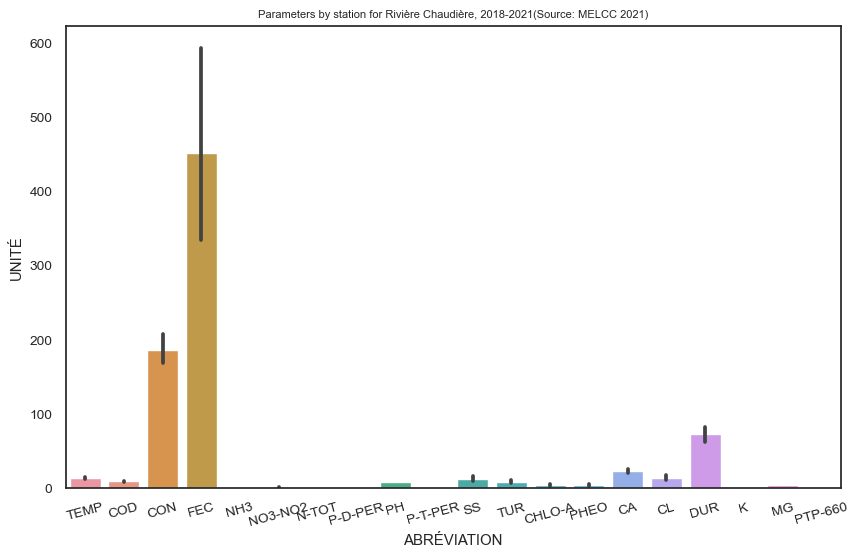

In [234]:
sns.barplot(data=ch1, 
             x="ABRÉVIATION", 
             y='UNITÉ'
            # hue="N° STATION"
           )
plt.title(label="Parameters by station for Rivière Chaudière, 2018-2021(Source: MELCC 2021)" ,
          fontdict={'fontsize':8}, loc='center')
plt.xticks(rotation=15)
plt.show()

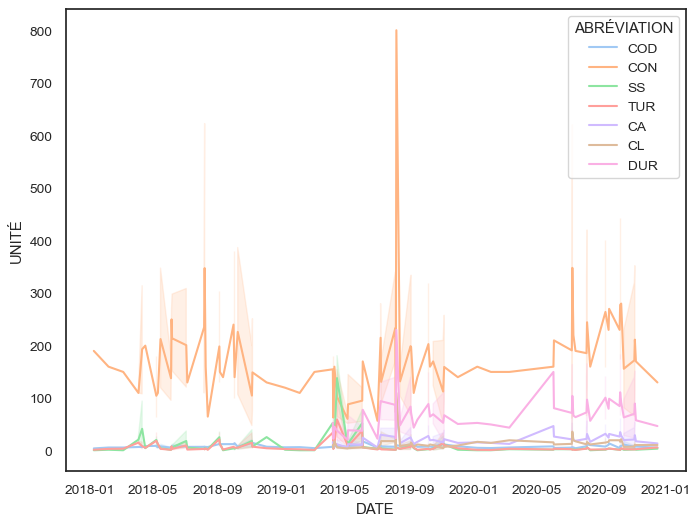

In [237]:
filtre=ch1.ABRÉVIATION.isin(['COD', 'CON', 'SS', 'TUR','CA', 'CL', 'DUR'])
plt.figure(figsize=(8,6))
sns.lineplot(data=ch1[filtre],
            y=ch1["UNITÉ"] , 
            x="DATE", 
            hue="ABRÉVIATION")
plt.title(label="",
          fontdict={'fontsize':10}, loc='center')
#plt.xticks(rotation=35)
plt.show()

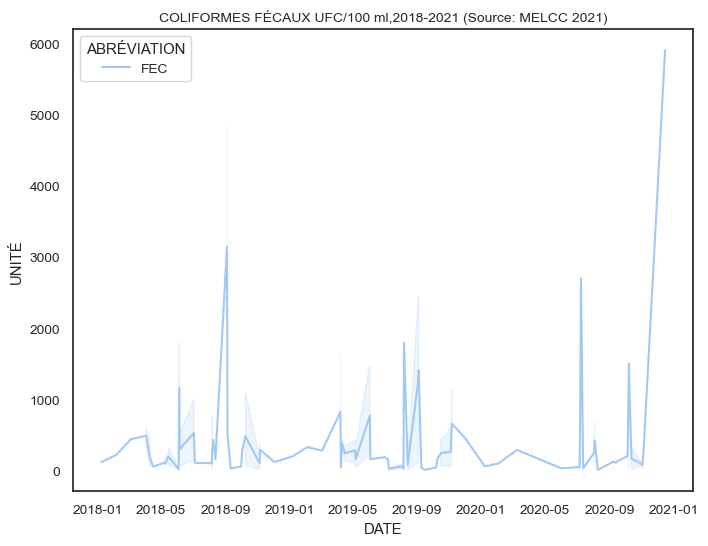

In [240]:
filtre=ch1.ABRÉVIATION.isin(['FEC'])
plt.figure(figsize=(8,6))
sns.lineplot(data=ch1[filtre],
            y=ch1["UNITÉ"] , 
            x="DATE", 
            hue="ABRÉVIATION")
plt.title(label="COLIFORMES FÉCAUX UFC/100 ml,2018-2021 (Source: MELCC 2021)",
          fontdict={'fontsize':10}, loc='center')
#plt.xticks(rotation=35)
plt.show()

In [244]:
df.columns

Index(['OBJECTID_x', 'NO_STATION', 'NomCoursEau', 'DESCRIPT', 'TYP_STAT',
       'TYP_SUIV', 'STAT_DEB', 'STAT_FIN', 'IQBP_N', 'IQBP_MED', 'IQBP_CLASS',
       'NH3_N', 'NH3_MED', 'NH3_Q90', 'CHLA_N', 'CHLA_MED', 'CHLA_Q90', 'CF_N',
       'CF_MED', 'CF_Q90', 'MES_N', 'MES_MED', 'MES_Q90', 'NOX_N', 'NOX_MED',
       'NOX_Q90', 'PTOT_N', 'PTOT_MED', 'PTOT_Q90', 'URL_ZGIEBV', 'URL_ZGIESL',
       'LAT', 'LONG', 'NOM_ZGIEBV', 'NOM_ZGIESL', 'ANNEE_FILTRE', 'geometry_x',
       'OBJECTID_y', 'SUPERF_QC_KM2', 'SUPERF_TOT_KM2', 'FRONTIERE',
       'PC_AGRICOLE', 'PC_FORESTIER', 'PC_HUMIDE', 'PC_AQUATIQUE',
       'PC_ANTHROPIQUE', 'PC_COUPE_REGENERATION', 'PC_SOL_NU_LANDE',
       'PC_NON_CLASSIFIE', 'ANNEE_UT', 'Shape_Length', 'Shape_Area',
       'geometry_y'],
      dtype='object')

#### IQBP_CLASS

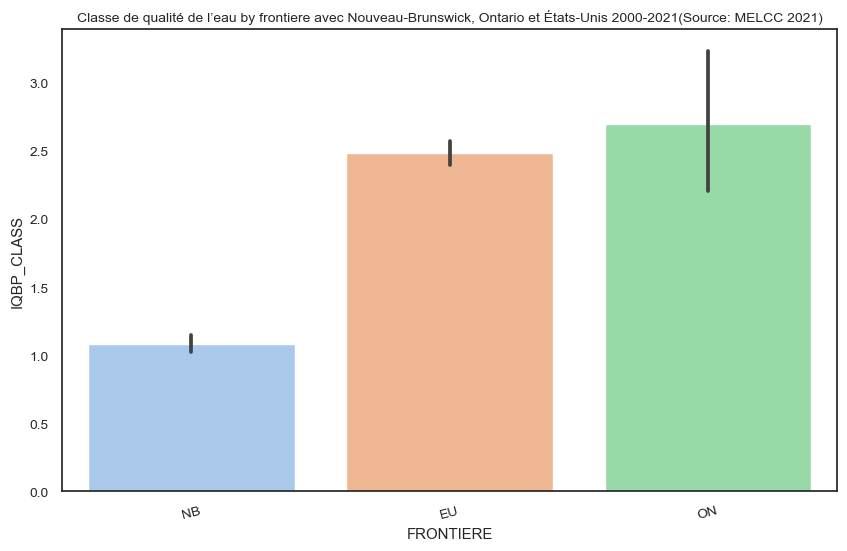

In [247]:

sns.barplot(data=df, 
             x="FRONTIERE", 
             y='IQBP_CLASS'
            # hue="N° STATION"
           )
plt.title(label="Classe de qualité de l’eau by frontiere avec Nouveau-Brunswick, Ontario et États-Unis 2000-2021(Source: MELCC 2021)" ,
          fontdict={'fontsize':10}, loc='center')
plt.xticks(rotation=15)
plt.show()

## NaN Values

In [242]:
df.shape

(5998, 53)

In [243]:
(df.isna().sum()/df.shape[0])*100

OBJECTID_x                0.000000
NO_STATION                0.000000
NomCoursEau               0.000000
DESCRIPT                  0.000000
TYP_STAT                  0.000000
TYP_SUIV                  0.000000
STAT_DEB                  0.000000
STAT_FIN                  0.000000
IQBP_N                    0.000000
IQBP_MED                  0.000000
IQBP_CLASS                0.000000
NH3_N                     0.700233
NH3_MED                   0.700233
NH3_Q90                   0.700233
CHLA_N                    1.700567
CHLA_MED                  1.700567
CHLA_Q90                  1.700567
CF_N                      0.716906
CF_MED                    0.716906
CF_Q90                    0.750250
MES_N                     0.700233
MES_MED                   0.700233
MES_Q90                   0.700233
NOX_N                     0.700233
NOX_MED                   0.700233
NOX_Q90                   0.700233
PTOT_N                   30.193398
PTOT_MED                 30.193398
PTOT_Q90            

* The FRONTIERE has 87% null value. We gone make a Yes/Non indicator: Yes, is a frontier other wise Non

* For the variable PC_AGRICOLE ,PC_FORESTIER , PC_HUMIDE,PC_AQUATIQUE ,PC_ANTHROPIQUE ,PC_COUPE_REGENERATION ,PC_SOL_NU_LANDE   ,PC_NON_CLASSIFIE we gone use 0.

In [ ]:
df_model= 'NomCoursEau', 'TYP_STAT', 'TYP_SUIV', 'IQBP_CLASS',
       'NH3_N', 'NH3_MED', 'NH3_Q90', 'CHLA_N', 'CHLA_MED', 'CHLA_Q90', 'CF_N',
       'CF_MED', 'CF_Q90', 'MES_N', 'MES_MED', 'MES_Q90', 'NOX_N', 'NOX_MED',
       'NOX_Q90', 'PTOT_N', 'PTOT_MED', 'PTOT_Q90', 'URL_ZGIEBV', 'URL_ZGIESL',
       'SUPERF_QC_KM2', 'SUPERF_TOT_KM2', 'PC_AGRICOLE', 'PC_FORESTIER', 'PC_HUMIDE', 'PC_AQUATIQUE',
       'PC_ANTHROPIQUE', 'PC_COUPE_REGENERATION', 'PC_SOL_NU_LANDE',
       'PC_NON_CLASSIFIE', 'Shape_Length', 'Shape_Area'